<a href="https://colab.research.google.com/github/DvirHayat/IntroToCloud/blob/main/FinalProject_Sloth/ManagerDash_sloth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies

In [1]:
!pip install matplotlib pandas firebase

### Imports

In [2]:
import pandas as pd
import json
import ipywidgets as widgets
from IPython.display import display, clear_output ,HTML
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from firebase import firebase
import seaborn as sns

### File selction - choose json file at run time or group file from firebase

#### Our team JSON file (stored in firebase)

In [3]:
# Initialize Firebase application
firebase_app = firebase.FirebaseApplication('https://cloudcourse-79588-default-rtdb.europe-west1.firebasedatabase.app/', None)

## Fetch data from Firebase
result = firebase_app.get('/dashboardData/', None)

# Create a list to store the data
data_list = []

# Iterate over the items in the result (which is a list of dictionaries)
for item in result:
    data_list.append(item)

# Specify the path to the JSON file
file_path = 'firebase_data.json'

# Write the list to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(data_list, json_file, indent=4)

# Read JSON file into DataFrame
filename=file_path

#### Generic suitable JSON file selection (JSON OnShape formatted)
filename and data frame will be determened by user selection:
> cancel upload - firebase JSON file (our group file)

> upload succeeded -file uploaded from device




In [4]:
from google.colab import files
try:
  uploaded = files.upload()
  # Get the filename from the uploaded dictionary
  filename = list(uploaded.keys())[0]
except:
  print("firebase data selected")
finally:
  data = pd.read_json(filename)

firebase data selected


### Open Data Frame in Google spreadsheet

In [5]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=data)

https://docs.google.com/spreadsheets/d/1o7ObgCHXhG1Nog4hoT7SCXLtcSxGGUcscFIUT60qZ-0#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


### General data cleansing and transforming

In [6]:

df = pd.DataFrame(data)
df['Time'] = pd.to_datetime(df['Time'])

# Extract date and hour from 'Time' column
df['Date'] = df['Time'].dt.date
df['Hour'] = df['Time'].dt.hour

df.set_index('Time', inplace=True)

### View Project related data - learning curve, attention graph
#### Added feature - export selected graph to PDF

In [7]:
# Create dropdowns for selecting document, data type, user, and graph type
doc_dropdown = widgets.Dropdown(
    options=['Whole Project'] + df['Document'].unique().tolist(),
    value='Whole Project',
    description='Document:',
)

data_type_dropdown = widgets.Dropdown(
    options=['Learning Curve', 'Working Hours'],
    value='Learning Curve',
    description='Data Type:',
)

user_dropdown = widgets.Dropdown(
    options=['All Users'] + df['User'].unique().tolist(),
    value='All Users',
    description='User:',
)

graph_type_dropdown = widgets.Dropdown(
    options=['Line'],
    value='Line',
    description='Graph Type:',
)

# Global figure object
global_fig = None

# Function to update the graph type options based on data type and user
def update_graph_type_options(data_type, user):
    if data_type == 'Learning Curve':
        graph_type_dropdown.options = ['Line']
    elif data_type == 'Working Hours':
        if user == 'All Users':
            graph_type_dropdown.options = ['Bar', 'Pie']
        else:
            graph_type_dropdown.options = ['Bar']
    graph_type_dropdown.value = graph_type_dropdown.options[0]

# Function to plot learning curve
def plot_learning_curve(filtered_df):
    global global_fig
    global_fig, ax = plt.subplots(figsize=(10, 6))
    undo_counts = filtered_df[filtered_df['Description'].str.contains('undo', case=False)].resample('D').size()
    redo_counts = filtered_df[filtered_df['Description'].str.contains('redo', case=False)].resample('D').size()
    delete_counts = filtered_df[filtered_df['Description'].str.contains('delete', case=False)].resample('D').size()

    num_days = (filtered_df.index.max() - filtered_df.index.min()).days + 1

    if not undo_counts.empty:
        ax.plot(undo_counts.index, undo_counts, marker='o', label='Undo Actions')
    if not redo_counts.empty:
        ax.plot(redo_counts.index, redo_counts, marker='o', label='Redo Actions')
    if not delete_counts.empty:
        ax.plot(delete_counts.index, delete_counts, marker='o', label='Delete Actions')

    ax.set_title('Learning Curve (Count of Undo, Redo, and Delete Actions)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Count of Actions')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.text(1.02, 0.5, f'Days: {num_days}', transform=ax.transAxes, fontsize=12, verticalalignment='center')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Add space for the title and Days text
    plt.subplots_adjust(top=0.85)  # Adjust the top margin for spacing
    plt.show()
    display(export_button)

# Function to plot working hours
def plot_working_hours(filtered_df, graph_type):
    global global_fig
    global_fig, ax = plt.subplots(figsize=(10, 6))
    filtered_df = filtered_df.copy()  # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    filtered_df['Hour'] = filtered_df.index.hour
    working_time = filtered_df.groupby(['Hour', 'User']).size().unstack(fill_value=0)
    hours = range(24)
    working_time = working_time.reindex(hours, fill_value=0)

    non_zero_cols = working_time.columns[(working_time != 0).any()]
    working_time = working_time[non_zero_cols]

    num_days = (filtered_df.index.max() - filtered_df.index.min()).days + 1

    if graph_type == 'Bar':
        working_time.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title('Working Hours during day time')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Count of Actions')
        ax.set_xticks(hours)
        ax.legend(title='User')

        for p in ax.patches:
            if p.get_height() > 0:
                ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

    elif graph_type == 'Pie':
        user_sums = working_time.sum(axis=0)
        if user_sums.sum() == 0:
            print("No data available to display.")
            return
        user_sums.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90)
        ax.set_ylabel('')
        ax.set_title('Working Hours during day time')

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Add space for the title and Days text
    if graph_type == 'Pie':
        ax.text(1.3, 0.5, f'Days: {num_days}', transform=ax.transAxes, fontsize=12, verticalalignment='center')
    else:
        ax.text(1.02, 0.5, f'Days: {num_days}', transform=ax.transAxes, fontsize=12, verticalalignment='center')
    plt.subplots_adjust(top=0.85)  # Adjust the top margin for spacing
    plt.show()
    display(export_button)

# Function to export the current graph to a PDF
def export_to_pdf(b):
    global global_fig
    if global_fig:
        doc = doc_dropdown.value
        data_type = data_type_dropdown.value
        user = user_dropdown.value
        export_date = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        title = f'{doc} - {data_type} - {user}\nDate of export: {export_date}'

        pdf_filename = f'{doc.lower().replace(" ", "_")}-{data_type.lower().replace(" ", "_")}-{user.lower().replace(" ", "_")}.pdf'

        with PdfPages(pdf_filename) as pdf:
            # Add title to the figure
            global_fig.suptitle(title, x=0.4, y=1.05, fontsize=14)
            pdf.savefig(global_fig, bbox_inches='tight')
            print(f"Graph exported to {pdf_filename}")
    else:
        print("No graph to export.")

# Create a button for exporting the graph to PDF
export_button = widgets.Button(description="Export to PDF")
export_button.on_click(export_to_pdf)

# Function to update the plot based on dropdown selections
def update_plot(doc, data_type, user, graph_type):
    if doc == 'Whole Project':
        filtered_df = df
    else:
        filtered_df = df[df['Document'] == doc]

    if user != 'All Users':
        filtered_df = filtered_df[filtered_df['User'] == user]

    if not filtered_df.empty:
        if data_type == 'Learning Curve':
            if filtered_df[filtered_df['Description'].str.contains('undo|redo|delete', case=False)].empty:
                print("No data available for the selected filters.")
            else:
                plot_learning_curve(filtered_df)
        elif data_type == 'Working Hours':
            if filtered_df.empty:
                print("No data available for the selected filters.")
            else:
                plot_working_hours(filtered_df, graph_type)
    else:
        print("No data available for the selected filters.")

# Create event handlers for dropdowns
def on_doc_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)
        update_plot(change['new'], data_type_dropdown.value, user_dropdown.value, graph_type_dropdown.value)

def on_data_type_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_graph_type_options(change['new'], user_dropdown.value)
        clear_output(wait=True)
        display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)
        update_plot(doc_dropdown.value, change['new'], user_dropdown.value, graph_type_dropdown.value)

def on_user_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_graph_type_options(data_type_dropdown.value, change['new'])
        clear_output(wait=True)
        display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)
        update_plot(doc_dropdown.value, data_type_dropdown.value, change['new'], graph_type_dropdown.value)

def on_graph_type_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)
        update_plot(doc_dropdown.value, data_type_dropdown.value, user_dropdown.value, change['new'])

doc_dropdown.observe(on_doc_change)
data_type_dropdown.observe(on_data_type_change)
user_dropdown.observe(on_user_change)
graph_type_dropdown.observe(on_graph_type_change)

# Initialize graph type options based on the default data type
update_graph_type_options(data_type_dropdown.value, user_dropdown.value)

# Display the dropdowns
display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)


Dropdown(description='Document:', options=('Whole Project', 'Industry 4.0 Project', 'Part Studio 1 Copy 1.stl'…

Dropdown(description='Data Type:', options=('Learning Curve', 'Working Hours'), value='Learning Curve')

Dropdown(description='User:', options=('All Users', 'StudentA1', 'StudentA2', 'StudentA3'), value='All Users')

Dropdown(description='Graph Type:', options=('Line',), value='Line')

### View User Related graphs:
* Activity table (actions in each relevant project)
* Top 5 most active projects
* Top 10 most common actions
* Activity in tabs of the top 3 active projects  

In [38]:
# Create user dropdown

# Define function to create user dropdown
def create_user_dropdown():
    return widgets.Dropdown(
        options=data['User'].unique(),
        description='User:',
        disabled=False,
    )

user_dropdown_1 = create_user_dropdown()
display(user_dropdown_1)

# Output widget for the table,active projects, top 10 actions
output_description_table = widgets.Output()
output_active_projects_chart = widgets.Output()
output_common_actions_chart = widgets.Output()
output_nested_pie_chart = widgets.Output()

display(output_description_table)
display(output_active_projects_chart)
display(output_common_actions_chart)
display(output_nested_pie_chart)

# Callback function to update the table
def update_description_table(user):
    user_data = data[data['User'] == user]
    description_counts = user_data['Document'].value_counts().reset_index()
    description_counts.columns = ['Document', 'Count']

    with output_description_table:
        output_description_table.clear_output()
        display(HTML(description_counts.to_html(index=False)))

# Link dropdown to the update function
def on_user_change_table(change):
    update_description_table(change['new'])

# Callback function to update the bar chart
def update_active_projects_chart(user):
    user_data = data[data['User'] == user]
    description_counts = user_data['Document'].value_counts().reset_index()
    description_counts.columns = ['Document', 'Count']

    top_active_projects = description_counts.head(5)

    # Truncate document names to a maximum length of 15 characters
    max_length = 50
    top_active_projects.loc[:, 'Document'] = top_active_projects['Document'].apply(
        lambda x: (x[:max_length] + '...') if len(x) > max_length else x
    )

    with output_active_projects_chart:
        output_active_projects_chart.clear_output()
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.barh(top_active_projects['Document'], top_active_projects['Count'], color='skyblue')
        ax.set_ylabel('Document')
        ax.set_xlabel('Count')
        ax.set_title('Top 5 Active Projects - (amount of actions)')

        # Annotate each bar with its value
        for index, value in enumerate(top_active_projects['Count']):
            ax.text(value, index, str(value), va='center', ha='left')

        plt.show()

# Link dropdown to the update function
def on_user_change_chart(change):
    update_active_projects_chart(change['new'])
# Callback function to update the bar chart
def update_common_actions_chart(user):
    user_data = data[data['User'] == user]
    common_actions = user_data['Description'].value_counts().head(10).reset_index()
    common_actions.columns = ['Description', 'Count']

    # Truncate description names to a maximum length of 15 characters
    max_length = 50

    common_actions.loc[:, 'Description'] = common_actions['Description'].apply(
        lambda x: (x[:max_length] + '...') if len(x) > max_length else x
    )

    with output_common_actions_chart:
        output_common_actions_chart.clear_output()
        fig, ax = plt.subplots(figsize=(10, 8))

        # Switch to horizontal bar chart using `barh()`
        ax.barh(common_actions['Description'], common_actions['Count'], color='lightgreen')
        ax.set_ylabel('Action')  # Now, 'Action' is on the y-axis
        ax.set_xlabel('Count')   # 'Count' is on the x-axis
        ax.set_title(f'10 Most Common Actions by User: {user}')

        # Annotate each bar with its value
        for index, value in enumerate(common_actions['Count']):
            ax.text(value, index, str(value), va='center', ha='left')  # Adjust annotation to align with horizontal bars

        plt.tight_layout()  # Adjust the layout to prevent label cut-offs
        plt.show()

# Link dropdown to the update function
def on_user_change_common_actions(change):
    update_common_actions_chart(change['new'])

# Callback function to update the nested pie chart
def update_nested_pie_chart(user):
    user_data = df[df['User'] == user]
    project_tab_counts = user_data.groupby(['Document', 'Tab']).size().reset_index(name='Count')

    top_projects = user_data['Document'].value_counts().head(3).index
    project_tab_counts = project_tab_counts[project_tab_counts['Document'].isin(top_projects)]

    # Limit document and tab names to 20 characters
    project_tab_counts['Document'] = project_tab_counts['Document'].apply(lambda x: x[:20])
    project_tab_counts['Tab'] = project_tab_counts['Tab'].apply(lambda x: x[:20])

    # Truncate labels to 15 characters if they exceed this length
    project_tab_counts['Tab'] = project_tab_counts['Tab'].apply(lambda x: x[:15])
    project_tab_counts['Document'] = project_tab_counts['Document'].apply(lambda x: x[:15])

    projects = project_tab_counts['Document'].unique()
    tab_counts_per_project = [project_tab_counts[project_tab_counts['Document'] == project]['Count'].sum() for project in projects]

    with output_nested_pie_chart:
        output_nested_pie_chart.clear_output()
        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot the inner layer (tabs) with a larger radius
        tabs = project_tab_counts['Tab']
        tab_counts = project_tab_counts['Count']
        ax.pie(
            tab_counts,
            labels=tabs,
            radius=2,
            wedgeprops=dict(width=0.6, edgecolor='w'),
            textprops={'fontsize': 10},
            labeldistance=1.1,  # Position labels further from the center
        )

        # Plot the outer layer (projects) with a smaller radius
        ax.pie(
            tab_counts_per_project,
            labels=projects,
            radius=1,
            wedgeprops=dict(width=0.6, edgecolor='w'),
            textprops={'fontsize': 10},
            labeldistance=0.6,  # Position labels further from the center
        )

        ax.set(aspect="equal", title=f'Nested Pie Chart of Tabs in Top 3 Projects for User: {user}')
        plt.tight_layout()
        plt.show()





def on_user_change_nested_pie(change):
    update_nested_pie_chart(change['new'])

user_dropdown_1.observe(on_user_change_common_actions, names='value')
user_dropdown_1.observe(on_user_change_chart, names='value')
user_dropdown_1.observe(on_user_change_table, names='value')
user_dropdown_1.observe(on_user_change_nested_pie, names='value')

Dropdown(description='User:', options=('StudentA1', 'StudentA2', 'StudentA3'), value='StudentA1')

Output()

Output()

Output()

Output()

### Topic related graphs

Dropdown(description='Document:', options=('Whole Project', 'Industry 4.0 Project', 'Part Studio 1 Copy 1.stl'…

Dropdown(description='User:', options=('All Users', 'StudentA1', 'StudentA2', 'StudentA3'), value='All Users')

Dropdown(description='Graph Type:', options=('Count Plot', 'Heatmap', 'Box Plot'), value='Count Plot')

Dropdown(description='Tab:', options=('N/A', 'Part Studio 2 Copy 1', 'Part Studio 2', 'Part Studio 1', 'Part S…

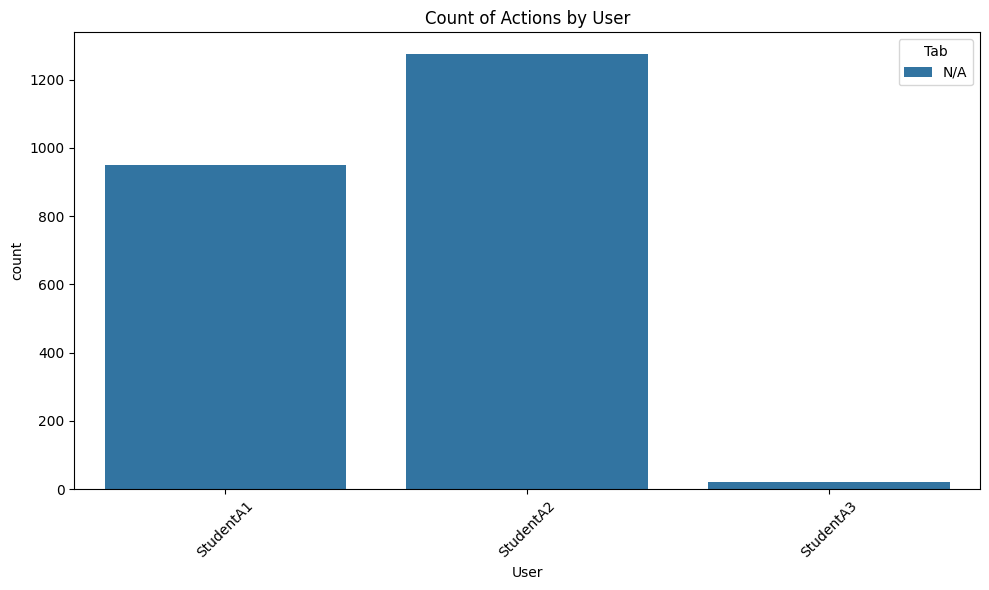

In [9]:
# Check for duplicate indices
duplicate_indices = df.index.duplicated()

if duplicate_indices.any():
    print("Duplicate indices found:")
    print(df[duplicate_indices])

    # Handle duplicate indices by resetting the index
    df = df.reset_index().drop_duplicates().set_index('Time')
    print("Duplicates handled. New DataFrame:")
    print(df)
else:
    print("No duplicate indices found.")

# Create dropdowns
doc_dropdown_topic = widgets.Dropdown(
    options=['Whole Project'] + df['Document'].unique().tolist(),
    value='Whole Project',
    description='Document:',
)

user_dropdown_topic = widgets.Dropdown(
    options=['All Users'] + df['User'].unique().tolist(),
    value='All Users',
    description='User:',
)

graph_type_dropdown_topic = widgets.Dropdown(
    options=['Count Plot', 'Heatmap', 'Box Plot'],
    value='Count Plot',
    description='Graph Type:',
)

tab_dropdown_topic = widgets.Dropdown(
    options=[],  # To be updated based on document selection
    value=None,
    description='Tab:',
)

# Update tab options based on the selected document
def update_tab_options_topic(doc):
    if doc == 'Whole Project':
        tabs = df['Tab'].unique().tolist()
    else:
        tabs = df[df['Document'] == doc]['Tab'].unique().tolist()
    tab_dropdown_topic.options = tabs
    tab_dropdown_topic.value = tabs[0] if tabs else None

# Plot functions
def plot_count_plot_topic(filtered_df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=filtered_df, x='User', hue='Tab')
    plt.title('Count of Actions by User')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_heatmap_topic(filtered_df):
    plt.figure(figsize=(12, 6))
    heatmap_data = filtered_df.groupby([filtered_df.index.date, filtered_df.index.hour]).size().unstack(fill_value=0)
    sns.heatmap(heatmap_data, cmap='coolwarm')
    plt.title('Heatmap of Actions over Time')
    plt.xlabel('Hour of Day')
    plt.ylabel('Date')
    plt.tight_layout()
    plt.show()

def plot_box_plot_topic(filtered_df):
    filtered_df['Hour'] = filtered_df.index.hour
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=filtered_df, x='Hour', y='User')
    plt.title('Distribution of Actions by Hour of Day')
    plt.tight_layout()
    plt.show()

# Update plot based on selections
def update_plot_topic(change):
    doc = doc_dropdown_topic.value
    graph_type = graph_type_dropdown_topic.value
    user = user_dropdown_topic.value
    tab = tab_dropdown_topic.value

    filtered_df = df[df['Document'] == doc] if doc != 'Whole Project' else df
    if user != 'All Users':
        filtered_df = filtered_df[filtered_df['User'] == user]
    if tab:
        filtered_df = filtered_df[filtered_df['Tab'] == tab]

    if filtered_df.empty:
        print("No data available for the selected filters.")
    else:
        if graph_type == 'Count Plot':
            plot_count_plot_topic(filtered_df)
        elif graph_type == 'Heatmap':
            plot_heatmap_topic(filtered_df)
        elif graph_type == 'Box Plot':
            plot_box_plot_topic(filtered_df)

# Attach event handlers
def on_doc_change_topic(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_tab_options_topic(change['new'])
        clear_output(wait=True)
        display(doc_dropdown_topic, user_dropdown_topic, graph_type_dropdown_topic, tab_dropdown_topic)
        update_plot_topic(None)

def on_graph_type_change_topic(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(doc_dropdown_topic, user_dropdown_topic, graph_type_dropdown_topic, tab_dropdown_topic)
        update_plot_topic(None)

def on_user_change_topic(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(doc_dropdown_topic, user_dropdown_topic, graph_type_dropdown_topic, tab_dropdown_topic)
        update_plot_topic(None)

def on_tab_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(doc_dropdown_topic, user_dropdown_topic, graph_type_dropdown_topic, tab_dropdown_topic)
        update_plot_topic(None)

doc_dropdown_topic.observe(on_doc_change_topic, names='value')
graph_type_dropdown_topic.observe(on_graph_type_change_topic, names='value')
user_dropdown_topic.observe(on_user_change_topic, names='value')
tab_dropdown_topic.observe(on_tab_change, names='value')

# Initialize tab options
update_tab_options_topic(doc_dropdown_topic.value)

# # Display widgets
# display(doc_dropdown_topic, user_dropdown_topic, graph_type_dropdown_topic, tab_dropdown_topic)

# # Initial plot
# update_plot_topic(None)


#Chatbot

In [10]:
import re
from rich.console import Console
from rich.prompt import Prompt


# Initialize Firebase application
firebase_app = firebase.FirebaseApplication('https://cloudcourse-79588-default-rtdb.europe-west1.firebasedatabase.app/', None)
responses = firebase_app.get('/chatbotData/', None)

def find_response(user_input):
    user_input = re.sub(r'\s+', ' ', user_input.strip())  # Normalize spaces
    for key in responses:
        if re.search(key, user_input, re.IGNORECASE):
            return responses[key]
    return responses.get('default', "I'm sorry, I don't understand.")

def on_button_click(b):
    user_input = input_box.value
    if user_input.lower() == 'exit':
        output_box.append_stdout("Chatbot: Goodbye!\n")
        return

    response = find_response(user_input)
    output_box.append_stdout(f"You: {user_input}\nChatbot: {response}\n")

# Setup widgets
input_box = widgets.Text(description="You: ", placeholder="Type your message here...")
send_button = widgets.Button(description="Send", button_style='success')
output_box = widgets.Output()

# Link button click event
send_button.on_click(on_button_click)

# Display the widgets
display(input_box, send_button, output_box)

# Initial chatbot greeting
with output_box:
    print("Help Chatbot - Type 'exit' to end the chat.")


Text(value='', description='You: ', placeholder='Type your message here...')

Button(button_style='success', description='Send', style=ButtonStyle())

Output()